In [156]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [157]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# AutoML 20200212

In [3]:
from pprint import pprint
import json
import os
import shutil
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from pathlib import Path
import glob
import magic
import sys
from IPython.display import Image as IPythonImage

In [67]:
sys.path.insert(0, "../")
from scripts.ensure_cached import cache_from_dropbox
from scripts.get_analysis_set import (
    get_analysis_set,
    get_prediction_needed_set,
    get_vision_prediction_set,
    get_pmc_ranked_result_set,
)

In [5]:
dropbox_pathway_ocr_dir = (
    Path("~/Dropbox (Gladstone)/Documents/pathway-ocr").expanduser().resolve()
)
paper_dir = Path("~/Dropbox (Gladstone)/Documents/PFOCR_25Years").expanduser().resolve()
local_data_dir = Path("~/Documents/pfocr/data").expanduser().resolve()

## Get Predictions

In [6]:
PROJECT_ID = "api-project-453052878726"
gs_dir = f"gs://{PROJECT_ID}-vcm/pfocr"

TODO: the code below will give an error if I re-run it:

In [7]:
prediction_needed_df = get_prediction_needed_set(
    gs_dir, local_data_dir.joinpath("images"), dropbox_pathway_ocr_dir
)
prediction_needed_df

/home/ariutta/Dropbox (Gladstone)/Documents/pathway-ocr/data/ncbi/unretrievable_images.tsv exists. Assuming already cached.


,gs_path
0,gs://api-project-453052878726-vcm/pfocr/images...
1,gs://api-project-453052878726-vcm/pfocr/images...
2,gs://api-project-453052878726-vcm/pfocr/images...
3,gs://api-project-453052878726-vcm/pfocr/images...
4,gs://api-project-453052878726-vcm/pfocr/images...
...,...
235075,gs://api-project-453052878726-vcm/pfocr/images...
235076,gs://api-project-453052878726-vcm/pfocr/images...
235077,gs://api-project-453052878726-vcm/pfocr/images...
235078,gs://api-project-453052878726-vcm/pfocr/images...


Export list of figures that need a classification prediction from Vision AutoML.

In [8]:
predictions_needed_f = local_data_dir.joinpath(
    "vision_automl/pfocr_20191102_single_po_10k/predict/235k_input.csv"
)
if not predictions_needed_f.exists():
    prediction_needed_df["gs_path"].to_csv(
        str(predictions_needed_f), header=False, index=False
    )

Update and run `gcloudy2` to train a model and use it to make predictions.

We trained four different models, using four different datasets. Here they are in order by time:

1. `pfocr_20191102_pco`: this one was first. Training data was labeled with `pathway`, `composite` and `other`.
2. `pfocr_20191102_multi`: label `composite` as both `pathway` and `other`.
3. `pfocr_20191102_single_po`: label `composite` as just `other`.
4. `pfocr_20191102_single_po_10k`: same as the previous one, but using a larger training set.

We classified the figures using model `pfocr_20191102_si_20200211121804`, based on training dataset `pfocr_20191102_single_po_10k`.

### Datasets

|  Name                       |Type                        |Total images|Labeled images|Last updated              |Status                  | 
|:----------------------------|:---------------------------|-----------:|-------------:|:-------------------------|:-----------------------|
|pfocr_20191102_single_po_10k |Single-Label Classification |15,406      |15,406        |Feb 11, 2020, 11:50:07 AM |Success: Training model |
|ICN3110045604978360320       |                            |            |              |                          |                        |
|pfocr_20191102_single_po     |Single-Label Classification |2,000 |2,000 |Jan 28, 2020, 6:54:43 PM |Success: Training model |||
|ICN918041631658082304        |
|pfocr_20191102_multi         |Multi-Label Classification |2,000 |2,000 |Jan 24, 2020, 4:24:33 PM |Success: Training model |||
|ICN1076063442802049024       |
|pfocr_20191102_pco           |Single-Label Classification |2,000 |2,000 |Jan 23, 2020, 5:51:59 PM |Success: Exporting data |
|ICN3530525239718969344       |

### Models

|Name|Dataset|Objective|Type|Images|Labels|Avg precision|Last updated|Deployed|Status|
|:---|:------|:--------|:---|-----:|-----:|------------:|:-----------|:-------|:-----|
|pfocr_20191102_si_20200211121804|pfocr_20191102_single_po_10k |Image classification |Cloud |15,406 |2 |0.977 |Feb 12, 2020, 10:11:58 AM |No|Success: Operation unknown |
|ICN8336211288774410240||
|pfocr_20191102_single_po|pfocr_20191102_single_po |Image classification |Cloud |2,000 |2 |0.98 |Jan 28, 2020, 8:53:54 PM |No|Success: Operation unknown |||
|ICN4000124456918843392
|pfocr_20191102_multi|pfocr_20191102_multi |Image classification |Cloud |2,000 |2 |0.959 |Jan 27, 2020, 5:13:46 PM |No|Success: Operation unknown |||
|ICN1436872581503254528
|pfocr_20191102_pc_20200123061048|pfocr_20191102_pco |Image classification |Cloud |2,000 |3 |0.938 |Jan 23, 2020, 9:29:50 PM |No|Success: Removing deployment 
|ICN7269737786389823488

Let's calculate MCC. Here's the equation:

```
MCC = (TP * TN - FP * FN) / sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
```

From the Google Cloud web UI, we get the following for `pfocr_20191102_single_po_10k` in terms of counts: 

* figures_total = 1540
* other_total = 1009
* pathway_total = 531
* pathway_fn (false negative) = 58
* pathway_fp (false positive) = 67

But the web UI doesn't give pathway_tn and pathway_tp. To get those values, we need to:
* export and download the results of training the model
* match the images from those results to the images we uploaded (GCloud reduces the size of the images and then names them as the SHA256SUM of those reduced size images.)
* take the results that were used as `TEST` and compare the manually-assigned labels with the AutoML predicted labels.

In [9]:
manually_labeled_f = local_data_dir.joinpath(
    "vision_automl/pfocr_20191102_single_po_10k/train/manually_labeled.csv"
)
manually_labeled_df = pd.read_csv(str(manually_labeled_f)).rename(
    columns={"figid": "gcloud_figure_path", "type.man": "type"}
)
manually_labeled_df["figid"] = manually_labeled_df["gcloud_figure_path"].str.replace(
    "gs://api-project-453052878726-vcm/pfocr/images/", ""
)
manually_labeled_df["local_figure_path"] = manually_labeled_df["figid"].apply(
    lambda figid: str(local_data_dir.joinpath(f"images/{figid}"))
)
manually_labeled_df

,gcloud_figure_path,type,figid,local_figure_path
0,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1073679__zmk0040531230006.jpg,/home/ariutta/Documents/pfocr/data/images/PMC1...
1,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1104157__pp1380027f01.jpg,/home/ariutta/Documents/pfocr/data/images/PMC1...
2,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1174980__zpq0280587940001.jpg,/home/ariutta/Documents/pfocr/data/images/PMC1...
3,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1299131__5-7400220f1.jpg,/home/ariutta/Documents/pfocr/data/images/PMC1...
4,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1451179__6772f6.jpg,/home/ariutta/Documents/pfocr/data/images/PMC1...
...,...,...,...,...
15404,gs://api-project-453052878726-vcm/pfocr/images...,other,PMC5624618__pone.0185625.g006.jpg,/home/ariutta/Documents/pfocr/data/images/PMC5...
15405,gs://api-project-453052878726-vcm/pfocr/images...,other,PMC4352509__IJE2015-505849.001.jpg,/home/ariutta/Documents/pfocr/data/images/PMC4...
15406,gs://api-project-453052878726-vcm/pfocr/images...,other,PMC6714138__JCMM-23-6034-g002.jpg,/home/ariutta/Documents/pfocr/data/images/PMC6...
15407,gs://api-project-453052878726-vcm/pfocr/images...,other,PMC3742217__ijms-14-13782f5.jpg,/home/ariutta/Documents/pfocr/data/images/PMC3...


Get perceptual hashes for manually labeled files. We're using blockhash as our perceptual hash.

In [10]:
manually_labeled_files_f = local_data_dir.joinpath("manually_labeled_files.csv")
if not manually_labeled_files_f.exists():
    manually_labeled_df["local_figure_path"].to_csv(
        manually_labeled_files_f, index=False, header=False
    )

Run this from the command line:
```
while IFS= read -r l; do blockhash "$l" | tee -a ../data/manually_labeled_files_phashes.txt; done < ../data/manually_labeled_files.csv
```

Choose "Export Data" from the [GCloud web UI](https://console.cloud.google.com/vision/datasets/ICN3110045604978360320;modelId=ICN8336211288774410240/evaluate?project=api-project-453052878726), download the resulting directory to `./data/vision_automl/pfocr_20191102_single_po_10k/train/export` and run this:

```
cd ./data/vision_automl/pfocr_20191102_single_po_10k/train/export
for f in files/*; do b=$(basename "$f"); cp "$f" ./files_exted/"$b".jpg; done
for f in $(ls -1 "./files_exted/"*.jpg); do blockhash "$f" | tee -a ../../../../../training_results_phashes.txt; done
```

In [11]:
manually_labeled_files_phashes_f = local_data_dir.joinpath(
    "manually_labeled_files_phashes.txt"
)

manually_labeled_files_phashes_df = (
    (
        pd.read_csv(
            str(manually_labeled_files_phashes_f),
            sep="\s+",
            names=["phash", "local_figure_path"],
        ).set_index("local_figure_path")
    )
    .join(
        manually_labeled_df.set_index("local_figure_path"), rsuffix="_test", how="inner"
    )
    .reset_index()
)

manually_labeled_files_phashes_df

,local_figure_path,phash,gcloud_figure_path,type,figid
0,/home/ariutta/Documents/pfocr/data/images/PMC1...,ba1f380fbb9b0099009b0399ff00bfbb9c919e159e659e...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1073679__zmk0040531230006.jpg
1,/home/ariutta/Documents/pfocr/data/images/PMC1...,60047e1e07f23d7e203e30063f3e3f9e00003ffc7c827d...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1104157__pp1380027f01.jpg
2,/home/ariutta/Documents/pfocr/data/images/PMC1...,fc7ffc77fc371c245fac00691f8dda479bc78bcf2bc302...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1174980__zpq0280587940001.jpg
3,/home/ariutta/Documents/pfocr/data/images/PMC1...,ffff21ff01ff01f7a3f795e3c5f38001800180e1b6fdaf...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1299131__5-7400220f1.jpg
4,/home/ariutta/Documents/pfocr/data/images/PMC1...,3cf73cf71c791c786db90c39618be599a69ba699ae1b8e...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,PMC1451179__6772f6.jpg
...,...,...,...,...,...
15401,/home/ariutta/Documents/pfocr/data/images/PMC5...,dfdfc3c141c1c1c1e1e17f7f6824642443010101ebeb7f...,gs://api-project-453052878726-vcm/pfocr/images...,other,PMC5624618__pone.0185625.g006.jpg
15402,/home/ariutta/Documents/pfocr/data/images/PMC4...,80808001fffff9fce1f0c1e08080ffff80ff80e18080ff...,gs://api-project-453052878726-vcm/pfocr/images...,other,PMC4352509__IJE2015-505849.001.jpg
15403,/home/ariutta/Documents/pfocr/data/images/PMC6...,ffff08800800ff8fffff9dff0420040004008400ffffff...,gs://api-project-453052878726-vcm/pfocr/images...,other,PMC6714138__JCMM-23-6034-g002.jpg
15404,/home/ariutta/Documents/pfocr/data/images/PMC3...,e7ffc0c040e0c0ffc1f9c1f9c0e9c0e940e1efff03cf03...,gs://api-project-453052878726-vcm/pfocr/images...,other,PMC3742217__ijms-14-13782f5.jpg


Get perceptual hashes for exported results from the training. We're using blockhashes.

In [12]:
training_results_df = None
for f in local_data_dir.joinpath(
    "vision_automl/pfocr_20191102_single_po_10k/train/export/"
).glob("image_classification_*.csv"):
    training_results_batch_df = pd.read_csv(
        str(f), names=["use", "gcloud_figure_path", "type"]
    )
    if not training_results_df is None:
        training_results_df = training_results_df.append(training_results_batch_df)
    else:
        training_results_df = training_results_batch_df

training_results_df["figure_sha256sum"] = training_results_df[
    "gcloud_figure_path"
].str.replace(
    "gs://api-project-453052878726-vcm/pfocr/pfocr_20191102_single_po_10k/train/export_data-pfocr_20191102_single_po_10k-2020-05-04T22:34:09.065Z/files/",
    "",
)
training_results_df["local_figure_path"] = training_results_df[
    "figure_sha256sum"
].apply(
    lambda figid: str(
        local_data_dir.joinpath(
            f"vision_automl/pfocr_20191102_single_po_10k/train/export/files/{figid}"
        )
    )
)

test_training_results_df = training_results_df[
    training_results_df["use"] == "TEST"
].copy(deep=True)
test_training_results_df

,use,gcloud_figure_path,type,figure_sha256sum,local_figure_path
1,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,726d4c047899e275e591e2405f1d390f36ce3fc4370d66...,/home/ariutta/Documents/pfocr/data/vision_auto...
15,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,pathway,ba51f009b2ce4f6a6aa78ab102e3c15b740db3de8f3489...,/home/ariutta/Documents/pfocr/data/vision_auto...
19,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,ce303351653b5cee497941992fcf50027fbf681cd208df...,/home/ariutta/Documents/pfocr/data/vision_auto...
36,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,3636200007d81d7c7171fca6441533be305756649c2764...,/home/ariutta/Documents/pfocr/data/vision_auto...
40,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,pathway,7434bd1db5abc39a548450aab534be54fdd5245e9378e6...,/home/ariutta/Documents/pfocr/data/vision_auto...
...,...,...,...,...,...
7672,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,ab05fb3cbbece5b4cec5c26c6452da5af64419321b48d8...,/home/ariutta/Documents/pfocr/data/vision_auto...
7674,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,pathway,129e08fb0119ced26f3b8bb97dc54b6862ea61c4f1da3c...,/home/ariutta/Documents/pfocr/data/vision_auto...
7685,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,762d6d78ff64aec39874d696f90a34a14591db0f4fc987...,/home/ariutta/Documents/pfocr/data/vision_auto...
7702,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,efece258a04a597dad9e1aa18bf452ee0dc458c1427f71...,/home/ariutta/Documents/pfocr/data/vision_auto...


In [13]:
training_results_phashes_f = local_data_dir.joinpath("training_results_phashes.txt")
training_results_phashes_df = pd.read_csv(
    str(training_results_phashes_f), sep="\s+", names=["phash", "relative_figure_path"]
)

training_results_phashes_df["figure_sha256sum"] = training_results_phashes_df[
    "relative_figure_path"
].str.replace(
    r"../data/vision_automl/pfocr_20191102_single_po_10k/train/export/files/", "",
)

training_results_phashes_df["local_figure_path_jpg"] = (
    "/home/ariutta/Documents/pfocr/data/vision_automl/pfocr_20191102_single_po_10k/train/export/files_exted/"
    + training_results_phashes_df["figure_sha256sum"]
    + ".jpg"
)

training_results_phashes_df = training_results_phashes_df.drop(
    columns=["relative_figure_path"]
)

test_training_results_phashes_df = training_results_phashes_df.set_index(
    "figure_sha256sum"
).join(
    test_training_results_df.set_index("figure_sha256sum"), rsuffix="_test", how="inner"
)

test_training_results_phashes_df

,phash,local_figure_path_jpg,use,gcloud_figure_path,type,local_figure_path
figure_sha256sum,,,,,,
003e5514dd38ab637d4a04c653980cb6dc80748e060dc124709b35bcb562dbfb,97f0827f00cf0c6f1c0f1f8f1fc31f209fe0c081def3f0...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,/home/ariutta/Documents/pfocr/data/vision_auto...
00470fa2386407a61099c5ea3b86e64e39613b31191af2b30a20040841db3f9c,ff81ff81d981c1c001011b03ff81fff3e03fe03fe03fe0...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,/home/ariutta/Documents/pfocr/data/vision_auto...
00d2ce545152fa63c4df47a64e11827cc45243aff3fb2c9de0cbb169919e1d2a,ffffdf808000eaa08000999b8389ffffdfdfc081e1c1e1...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,/home/ariutta/Documents/pfocr/data/vision_auto...
00f454628d80ad059d7e43d2a6a58312f39d45618afe915852320e6242600bc5,c79722f8aa46ab0b030bc233eb0fc7c7c7cf008221dfff...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,pathway,/home/ariutta/Documents/pfocr/data/vision_auto...
00fa39ff3c3afb796a32a57fc5837c3dad415dac7b9bb92fc9f69137529735ec,c1ff81ff81ff8fffe4ffc007c3e1c3c1e7c001f37cfb46...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,pathway,/home/ariutta/Documents/pfocr/data/vision_auto...
...,...,...,...,...,...,...
ff69ef155170b22d899fff4ea8f141ada7135ae158581c9c32013c496fea585d,ec7f806fc467806380218023ffff1ce718e30c618430ff...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,/home/ariutta/Documents/pfocr/data/vision_auto...
ffb90aaa9da9a461b8fceecfbdfeb865982bed654a9d282a1d78adf970332594,d807fff7c007c007c001ef671f3c63f040007ffe1e3c7e...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,/home/ariutta/Documents/pfocr/data/vision_auto...
ffcac38c0feab2237e4672ab41fee69efa6d7c3306a22e623c5c62a5b5e24902,bfff7e7f81008100b73d063d063d063d8715c7158755c7...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,other,/home/ariutta/Documents/pfocr/data/vision_auto...


Map outputs to inputs.

In [14]:
import Levenshtein as lev
import math


def get_closest_phash(reference_phashes, input_phash):
    # for best performance, handle exact matches separately, before using this function
    closest_phash = None
    min_distance = math.inf
    for reference_phash in reference_phashes:
        ldistance = lev.distance(input_phash, reference_phash)
        if min_distance > ldistance:
            min_distance = ldistance
            closest_phash = reference_phash
    return closest_phash


def map_phashes(reference_phashes, input_phashes):
    reference_phashes = set(reference_phashes)
    input_phashes = set(input_phashes)
    intersected_phashes = reference_phashes & input_phashes

    input2reference_mappings = dict()
    for phash in intersected_phashes:
        input2reference_mappings[phash] = phash

    nonintersected_input_phashes = input_phashes - intersected_phashes
    for phash in nonintersected_input_phashes:
        input2reference_mappings[phash] = get_closest_phash(reference_phashes, phash)

    return input2reference_mappings

In [15]:
manually_labeled_files_phashes = set(manually_labeled_files_phashes_df["phash"])
test_training_results_phashes = set(test_training_results_phashes_df["phash"])

test_training_results_phash_to_manually_labeled_files_phash_mappings = map_phashes(
    manually_labeled_files_phashes, test_training_results_phashes
)

In [16]:
input_phashes_count = len(test_training_results_phashes)

unique_input_phashes = (
    test_training_results_phash_to_manually_labeled_files_phash_mappings.keys()
)
unique_reference_phashes = set(
    test_training_results_phash_to_manually_labeled_files_phash_mappings.values()
)

if input_phashes_count != len(unique_input_phashes) or input_phashes_count != len(
    unique_reference_phashes
):
    print("The mapping from input to reference phashes was not a perfect 1:1.")

In [17]:
def map_to_figid(test_training_results_phash):
    manually_labeled_files_phash = test_training_results_phash_to_manually_labeled_files_phash_mappings[
        test_training_results_phash
    ]
    return manually_labeled_files_phashes_df[
        manually_labeled_files_phashes_df["phash"] == manually_labeled_files_phash
    ].iloc[0]["figid"]


test_training_results_phashes_df["figid"] = test_training_results_phashes_df[
    "phash"
].apply(map_to_figid)

In [18]:
test_training_results_phashes_df.to_csv(
    local_data_dir.joinpath("test_training_results_phashes.csv"), header=True
)

In [19]:
train_merged_df = manually_labeled_files_phashes_df.set_index("figid").merge(
    test_training_results_phashes_df.drop(columns=["type"]).set_index("figid"),
    on="figid",
    how="inner",
    suffixes=["_manually_labeled_file", "_training_result"],
)
train_merged_df

,local_figure_path_manually_labeled_file,phash_manually_labeled_file,gcloud_figure_path_manually_labeled_file,type,phash_training_result,local_figure_path_jpg,use,gcloud_figure_path_training_result,local_figure_path_training_result
figid,,,,,,,,,
PMC1299131__5-7400220f1.jpg,/home/ariutta/Documents/pfocr/data/images/PMC1...,ffff21ff01ff01f7a3f795e3c5f38001800180e1b6fdaf...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,e7e701e701e701e7a3f795e3c5f38001800180e1b6fdaf...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...
PMC2172842__200303023f5.jpg,/home/ariutta/Documents/pfocr/data/images/PMC2...,fbfff3f1f3e0f7e0f7f1f460e02e026e402ef020f7f0f7...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,fbfff3f1f3e0f7e0f7f1f460e02e026e402ef020f7f0f7...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...
PMC2593186__zek0120832500008.jpg,/home/ariutta/Documents/pfocr/data/images/PMC2...,002f000f9fefbfc4bf93bf28bc3818121246b646b66eb6...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,002f000f9fefbfc4bf93bf28bc3818121246b646b66eb6...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...
PMC2666844__gcr1_4ap0013f5.jpg,/home/ariutta/Documents/pfocr/data/images/PMC2...,00007c7f7c7f781f783e00007c7e7e7e783e783e7c7e7e...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,00007c7f7c7f781f783e00007c7e7e7e783e783e7c7e7e...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...
PMC2677397__1752-0509-2-111-5.jpg,/home/ariutta/Documents/pfocr/data/images/PMC2...,72e60e3f8638067b0e731ef90c393e310e798c383c3b3e...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,72e60e3f8638067b0e731ef90c333e310e798c383c3b3e...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...
...,...,...,...,...,...,...,...,...,...
PMC5133833__ijms-17-01832-g001.jpg,/home/ariutta/Documents/pfocr/data/images/PMC5...,ffff575500110067005780918999ffffa185ffffdd1301...,gs://api-project-453052878726-vcm/pfocr/images...,other,ffff575500110067005780918999ffffa185ffffdd1301...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...
PMC6449277__TCA-10-909-g005.jpg,/home/ariutta/Documents/pfocr/data/images/PMC6...,f87f807f806f8063c3e1806180ffe0fffbff807f806680...,gs://api-project-453052878726-vcm/pfocr/images...,other,f87f807f806f8063c3e1806180ffe0fffb7f807f806780...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...
PMC3162439__zbc0391175400001.jpg,/home/ariutta/Documents/pfocr/data/images/PMC3...,fdff8e880488f889f7ffff8d80801088f1ffff008300ff...,gs://api-project-453052878726-vcm/pfocr/images...,other,fdff8f800488f889f7ffff8d80801088f1ffff008300ff...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...


*************************************************************************************
  ffff21ff01ff01f7a3f795e3c5f38001800180e1b6fdaffda5f3fff1fff9ffff
  e7e701e701e701e7a3f795e3c5f38001800180e1b6fdaffda4e1e7e1e7e1e7e7
    image_f: /home/ariutta/Documents/pfocr/data/images/PMC1299131__5-7400220f1.jpg


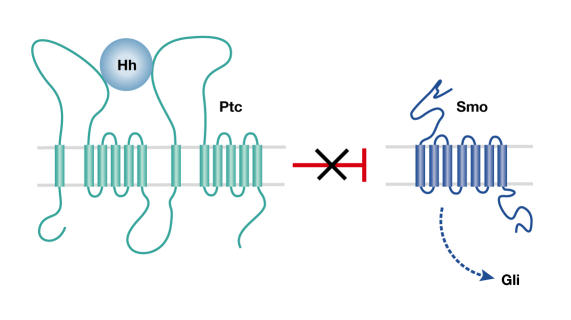

    image_f: /home/ariutta/Documents/pfocr/data/vision_automl/pfocr_20191102_single_po_10k/train/export/files_exted/75ef217b96b2f7406efb8cc9776a5c235f65082a82eed1f48a2e04c56c15535a.jpg


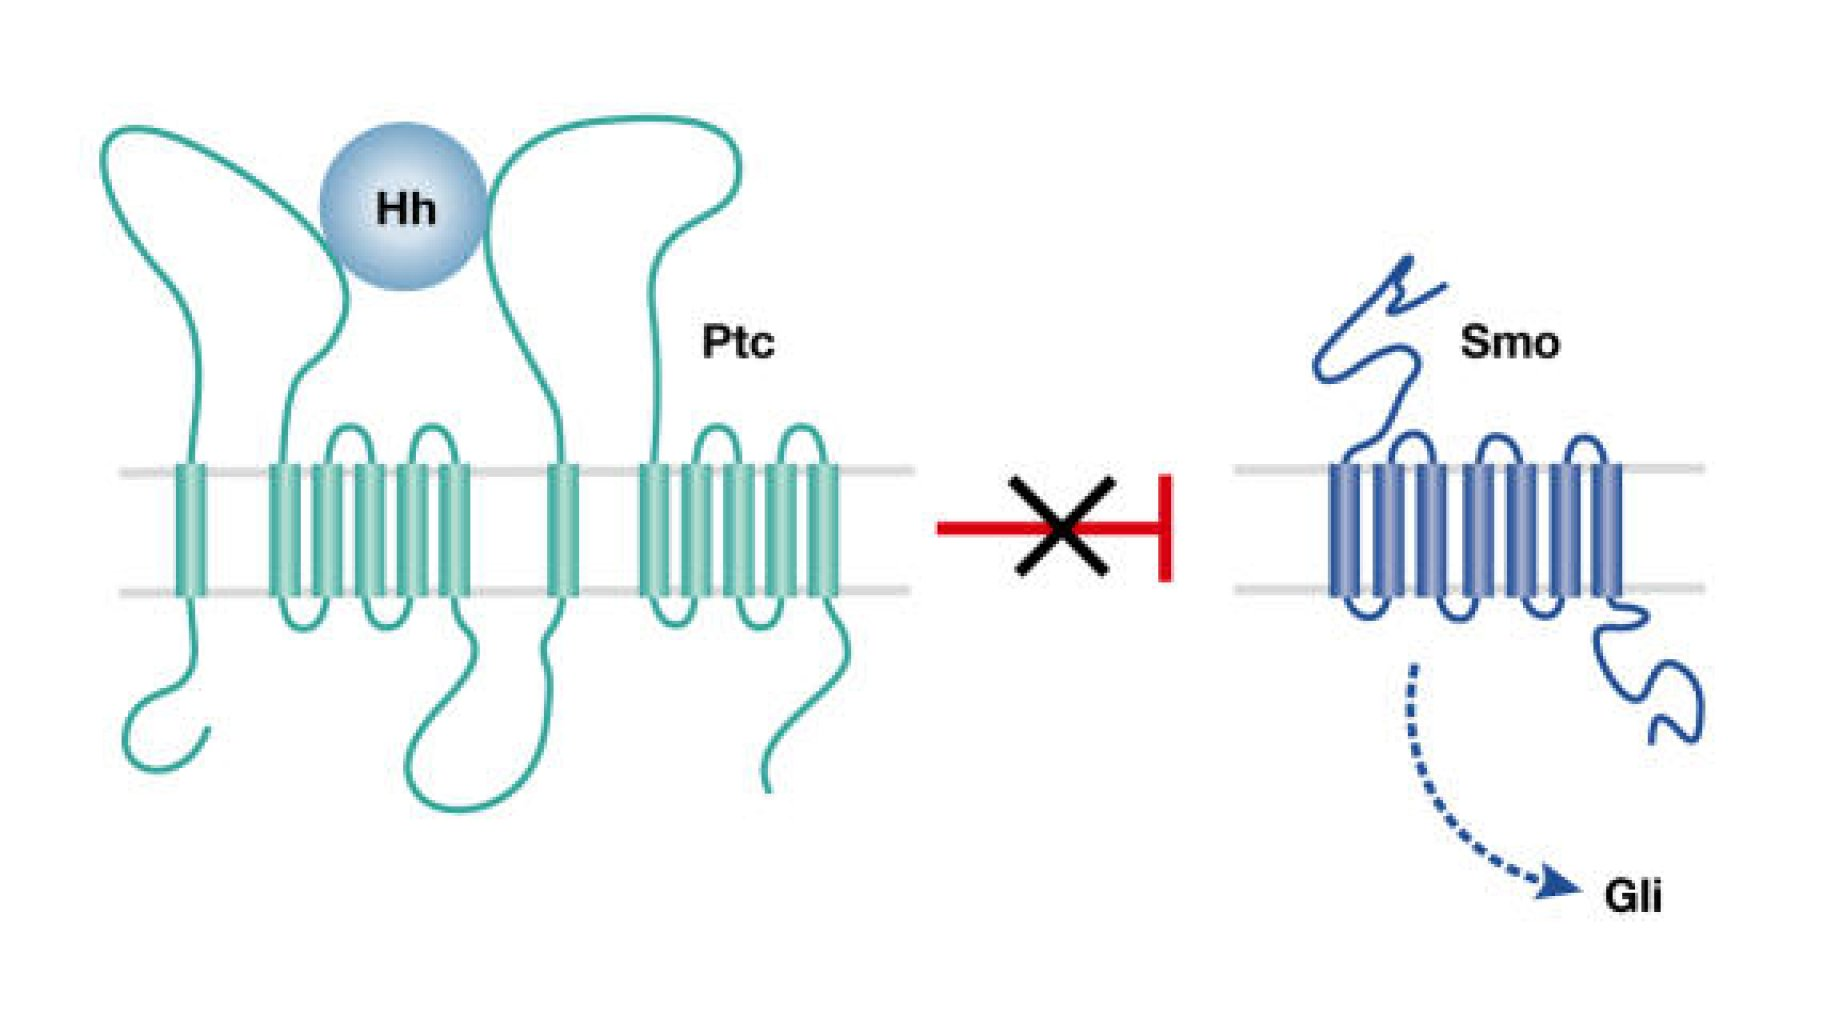

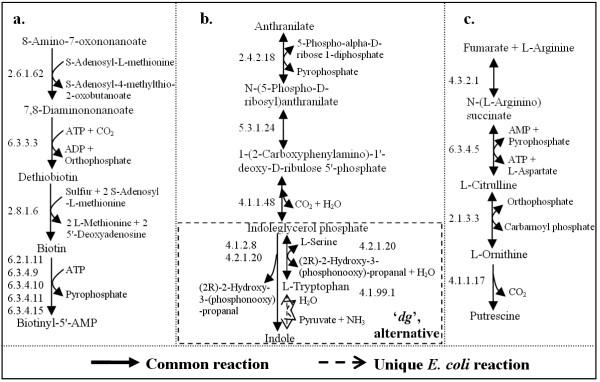

equal
equal
equal
*************************************************************************************
  72e60e3f8638067b0e731ef90c393e310e798c383c3b3e0f187b3e4bfecf4002
  72e60e3f8638067b0e731ef90c333e310e798c383c3b3e0f187b3e4bfecf4002
    image_f: /home/ariutta/Documents/pfocr/data/images/PMC2677397__1752-0509-2-111-5.jpg
    image_f: /home/ariutta/Documents/pfocr/data/vision_automl/pfocr_20191102_single_po_10k/train/export/files_exted/1182c15d4a6e7467c1dc6f9d2c83d9a7a6a23d999f9851addba3eea87c7cf312.jpg


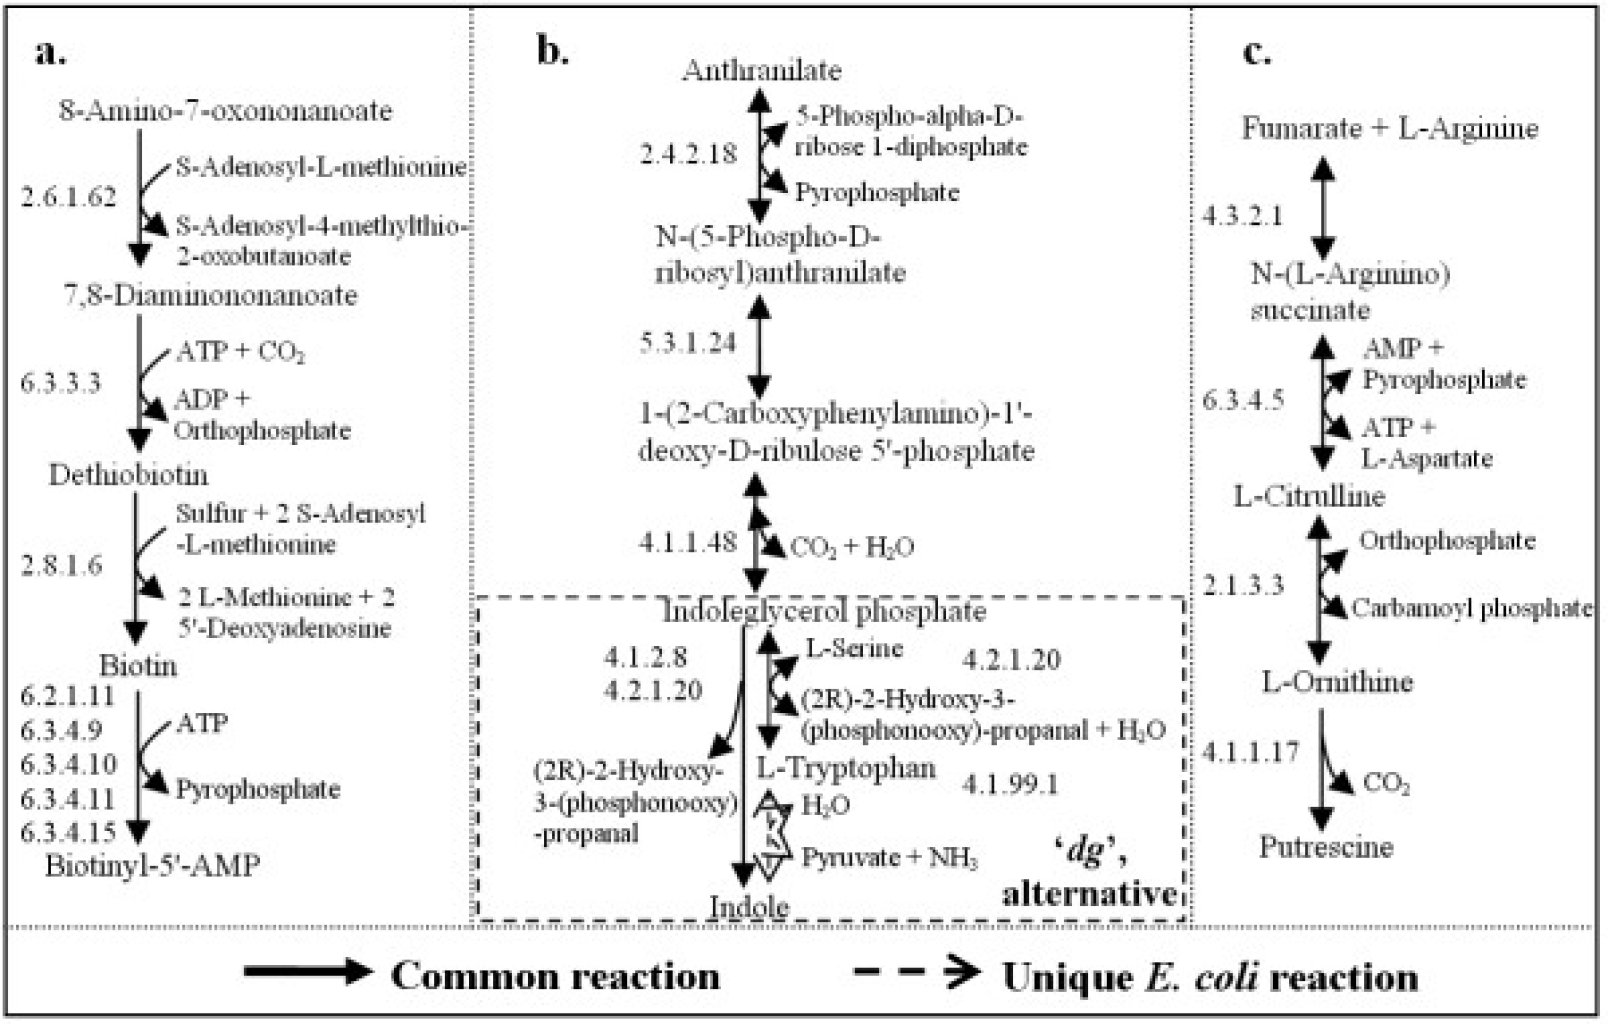

In [20]:
for i, row in train_merged_df.head().iterrows():
    phash_manually_labeled_file = row["phash_manually_labeled_file"]
    phash_training_result = row["phash_training_result"]

    if phash_manually_labeled_file == phash_training_result:
        print("equal")
        continue

    local_figure_path_manually_labeled_file = row[
        "local_figure_path_manually_labeled_file"
    ]
    local_figure_path_jpg = row["local_figure_path_jpg"]
    print(
        "*************************************************************************************"
    )
    print("  " + phash_manually_labeled_file)
    print("  " + phash_training_result)
    for image_f in [local_figure_path_manually_labeled_file, local_figure_path_jpg]:
        print(f"    image_f: {image_f}")
        jpg = Path(image_f)
        if jpg.is_file():
            display(IPythonImage(filename=image_f))
        else:
            print("    missing")

In [21]:
len(train_merged_df[train_merged_df["type"] == "pathway"])

531

In [22]:
len(train_merged_df[train_merged_df["type"] == "other"])

1009

In [23]:
vision_prediction_df = get_vision_prediction_set(
    local_data_dir.joinpath(
        "vision_automl/pfocr_20191102_single_po_10k/predict/235k_export"
    )
)
vision_prediction_df

,figid,other_score,pathway_score
0,PMC6069781__12859_2018_2175_Fig7_HTML.jpg,0.782716,0.217284
1,PMC6070024__mcy06802.jpg,0.045954,0.954046
2,PMC6070341__nihms980745f2.jpg,0.934831,0.065169
3,PMC6070353__nihms957693f1.jpg,0.956936,0.043064
4,PMC6070531__41419_2018_889_Fig2_HTML.jpg,0.904666,0.095334
...,...,...,...
235075,PMC4579082__pbio.1002253.g010.jpg,0.973409,0.026591
235076,PMC4579850__ncomms9256-f3.jpg,0.945037,0.054963
235077,PMC4579868__ol-10-04-2055-g04.jpg,0.940856,0.059144
235078,PMC4579919__ol-10-04-2227-g01.jpg,0.958038,0.041962


In [24]:
train_merged_all_df = train_merged_df.merge(
    vision_prediction_df.set_index("figid"),
    on="figid",
    how="inner",
    suffixes=["", "_vision"],
)
train_merged_all_df

,local_figure_path_manually_labeled_file,phash_manually_labeled_file,gcloud_figure_path_manually_labeled_file,type,phash_training_result,local_figure_path_jpg,use,gcloud_figure_path_training_result,local_figure_path_training_result,other_score,pathway_score
figid,,,,,,,,,,,
PMC1299131__5-7400220f1.jpg,/home/ariutta/Documents/pfocr/data/images/PMC1...,ffff21ff01ff01f7a3f795e3c5f38001800180e1b6fdaf...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,e7e701e701e701e7a3f795e3c5f38001800180e1b6fdaf...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...,0.042405,0.957595
PMC2172842__200303023f5.jpg,/home/ariutta/Documents/pfocr/data/images/PMC2...,fbfff3f1f3e0f7e0f7f1f460e02e026e402ef020f7f0f7...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,fbfff3f1f3e0f7e0f7f1f460e02e026e402ef020f7f0f7...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...,0.166081,0.833919
PMC2593186__zek0120832500008.jpg,/home/ariutta/Documents/pfocr/data/images/PMC2...,002f000f9fefbfc4bf93bf28bc3818121246b646b66eb6...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,002f000f9fefbfc4bf93bf28bc3818121246b646b66eb6...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...,0.088472,0.911528
PMC2666844__gcr1_4ap0013f5.jpg,/home/ariutta/Documents/pfocr/data/images/PMC2...,00007c7f7c7f781f783e00007c7e7e7e783e783e7c7e7e...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,00007c7f7c7f781f783e00007c7e7e7e783e783e7c7e7e...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...,0.141239,0.858761
PMC2677397__1752-0509-2-111-5.jpg,/home/ariutta/Documents/pfocr/data/images/PMC2...,72e60e3f8638067b0e731ef90c393e310e798c383c3b3e...,gs://api-project-453052878726-vcm/pfocr/images...,pathway,72e60e3f8638067b0e731ef90c333e310e798c383c3b3e...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...,0.073890,0.926110
...,...,...,...,...,...,...,...,...,...,...,...
PMC5133833__ijms-17-01832-g001.jpg,/home/ariutta/Documents/pfocr/data/images/PMC5...,ffff575500110067005780918999ffffa185ffffdd1301...,gs://api-project-453052878726-vcm/pfocr/images...,other,ffff575500110067005780918999ffffa185ffffdd1301...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...,0.999985,0.000015
PMC6449277__TCA-10-909-g005.jpg,/home/ariutta/Documents/pfocr/data/images/PMC6...,f87f807f806f8063c3e1806180ffe0fffbff807f806680...,gs://api-project-453052878726-vcm/pfocr/images...,other,f87f807f806f8063c3e1806180ffe0fffb7f807f806780...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...,0.999395,0.000605
PMC3162439__zbc0391175400001.jpg,/home/ariutta/Documents/pfocr/data/images/PMC3...,fdff8e880488f889f7ffff8d80801088f1ffff008300ff...,gs://api-project-453052878726-vcm/pfocr/images...,other,fdff8f800488f889f7ffff8d80801088f1ffff008300ff...,/home/ariutta/Documents/pfocr/data/vision_auto...,TEST,gs://api-project-453052878726-vcm/pfocr/pfocr_...,/home/ariutta/Documents/pfocr/data/vision_auto...,0.946936,0.053064


Verifying it's safe to not worry about values exactly on the border line between pathway and other.

In [25]:
len(train_merged_all_df[(train_merged_all_df["pathway_score"] == 0.5)])

0

In [26]:
len(train_merged_all_df[(train_merged_all_df["other_score"] == 0.5)])

0

Get true and false positives and negatives.

In [27]:
pathway_fn = len(
    train_merged_all_df[
        (train_merged_all_df["type"] == "pathway")
        & (train_merged_all_df["pathway_score"] < 0.5)
    ]
)
pathway_fn

58

In [28]:
pathway_tp = len(
    train_merged_all_df[
        (train_merged_all_df["type"] == "pathway")
        & (train_merged_all_df["pathway_score"] > 0.5)
    ]
)
pathway_tp

473

In [29]:
pathway_fp = len(
    train_merged_all_df[
        (train_merged_all_df["type"] == "other")
        & (train_merged_all_df["pathway_score"] > 0.5)
    ]
)
pathway_fp

67

In [30]:
pathway_tn = len(
    train_merged_all_df[
        (train_merged_all_df["type"] == "other")
        & (train_merged_all_df["pathway_score"] < 0.5)
    ]
)
pathway_tn

942

In [31]:
MCC = (pathway_tp * pathway_tn - pathway_fp * pathway_fn) / math.sqrt(
    (pathway_tp + pathway_fp)
    * (pathway_tp + pathway_fn)
    * (pathway_tn + pathway_fp)
    * (pathway_tn + pathway_fn)
)
MCC

0.8211415168158339

## Analyze Predictions

### Load Data

In [136]:
pmc_ranked_result_df = get_pmc_ranked_result_set()

# note: this is not the analysis_df from get_analysis_set()
analysis_df = (
    (
        vision_prediction_df.join(
            pmc_ranked_result_df[["figid", "pmc_ranked_result_index"]]
            .drop_duplicates()
            .set_index("figid"),
            on="figid",
        )
    )
    .sort_values("pmc_ranked_result_index")
    .rename(columns={"pmc_ranked_result_index": "index"})
    .set_index("index")
    .reset_index()
    .rename(columns={"index": "pmc_ranked_result_index"})
)
# analysis_df["pmc_ranked_result_index"] = analysis_df["index"]
analysis_df

,pmc_ranked_result_index,figid,other_score,pathway_score
0,0,PMC4309023__bau126f3p.jpg,0.970088,0.029912
1,1,PMC4383884__gku1026fig5.jpg,0.517079,0.482921
2,2,PMC3487967__1471-2105-13-218-2.jpg,0.055084,0.944916
3,3,PMC3497732__pnas.1209002109fig01.jpg,0.104117,0.895883
4,4,PMC6137129__fimmu-09-02055-g0006.jpg,0.890991,0.109009
...,...,...,...,...
235075,235076,PMC1068650__zac0040548460001.jpg,0.848846,0.151154
235076,235077,PMC5724390__nihms899325f3.jpg,0.956804,0.043196
235077,235078,PMC6177479__41598_2018_32984_Fig2_HTML.jpg,0.980278,0.019722
235078,235079,PMC4821809__nihms773291f1.jpg,0.947299,0.052701


### Threshold & Pathway Ratio

In the following discussion, *pathway ratio* is a rolling window calculation of
`pathway_count / (pathway_count + other_count)`.

In [137]:
window_size = 1000
max_point_count = 200


def add_pathway_score_threshold_column(df, threshold):
    working_df = df[["pathway_score"]].copy()
    working_df["pathway"] = working_df["pathway_score"] >= threshold
    # excluding the first rows before we get enough to do a sum, so
    # that we avoid NaNs
    rolling_df = working_df.rolling(window_size).sum()[["pathway"]][(window_size - 1) :]
    rolling_df[f"pathway_score_threshold_{threshold}"] = (
        rolling_df["pathway"] / window_size
    )
    rolling_df = rolling_df.drop(columns=["pathway"])
    return rolling_df

#### When Sorted by PMC Relevance Algorithm

In [138]:
pmc_pathway_ratio_df = None
threshold_start = 0.2
threshold_end = 0.7
step = 1

for i in range(int(threshold_start * 10), int(threshold_end * 10 + 1), step):
    threshold = i / 10
    new_df = add_pathway_score_threshold_column(analysis_df, threshold)
    if not pmc_pathway_ratio_df is None:
        pmc_pathway_ratio_df = pmc_pathway_ratio_df.join(new_df)
    else:
        pmc_pathway_ratio_df = new_df

pmc_pathway_ratio_df = pmc_pathway_ratio_df.take(
    range(
        0, len(pmc_pathway_ratio_df), int(len(pmc_pathway_ratio_df) / max_point_count),
    )
)
pmc_pathway_ratio_df = pmc_pathway_ratio_df.reset_index()
pmc_pathway_ratio_df

,index,pathway_score_threshold_0.2,pathway_score_threshold_0.3,pathway_score_threshold_0.4,pathway_score_threshold_0.5,pathway_score_threshold_0.6,pathway_score_threshold_0.7
0,999,0.717,0.697,0.682,0.669,0.654,0.622
1,2169,0.746,0.719,0.704,0.685,0.668,0.637
2,3339,0.715,0.698,0.680,0.659,0.630,0.609
3,4509,0.733,0.711,0.700,0.683,0.669,0.630
4,5679,0.689,0.664,0.639,0.622,0.597,0.570
...,...,...,...,...,...,...,...
196,230319,0.078,0.070,0.065,0.062,0.058,0.053
197,231489,0.069,0.065,0.061,0.059,0.057,0.053
198,232659,0.084,0.081,0.077,0.076,0.074,0.070
199,233829,0.097,0.086,0.081,0.077,0.071,0.063


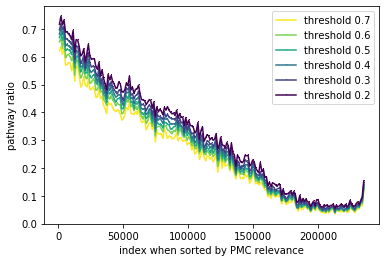

In [139]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

colors = cm.viridis(
    np.linspace(
        1, 0, len(range(int(threshold_start * 10), int(threshold_end * 10 + 1)))
    )
)
for threshold_integer, color in zip(
    range(int(threshold_end * 10), int(threshold_start * 10 - 1), -1 * step), colors
):
    threshold = threshold_integer / 10
    y_column = f"pathway_score_threshold_{threshold}"
    ax1.plot(
        pmc_pathway_ratio_df["index"],
        pmc_pathway_ratio_df[y_column],
        marker=",",
        c=color,
        label=f"threshold {threshold}",
    )

plt.legend(loc="upper right")
plt.xlabel("index when sorted by PMC relevance")
plt.ylabel("pathway ratio")
plt.show()

Why does the pathway ratio starts rising again at the end? I thought it was because of the figures that came from the 100k set but were not in the 235k set, however, there are no `NaN` values at the tail end of `analysis_df["pmc_ranked_result_index"]`:

In [140]:
analysis_df["pmc_ranked_result_index"].tail()

235075    235076
235076    235077
235077    235078
235078    235079
235079    235080
Name: pmc_ranked_result_index, dtype: int64

It appears, however, that there is a slight discrepancy between the columns `index` and `pmc_ranked_result_index`:

In [141]:
analysis_df.dtypes

pmc_ranked_result_index      int64
figid                       object
other_score                float64
pathway_score              float64
dtype: object

In [144]:
reset_analysis_df = analysis_df.reset_index()
set(reset_analysis_df["index"]) - set(analysis_df["pmc_ranked_result_index"])

{72606}

In [145]:
reset_analysis_df[reset_analysis_df["index"] == 72606]

,index,pmc_ranked_result_index,figid,other_score,pathway_score
72606,72606,72607,PMC6522871__MMR-19-06-5053-g01.jpg,0.073383,0.926617


In [146]:
set(analysis_df["pmc_ranked_result_index"]) - set(reset_analysis_df["index"])

{235080}

In [147]:
analysis_df[analysis_df["pmc_ranked_result_index"] == 235080]

,pmc_ranked_result_index,figid,other_score,pathway_score
235079,235080,PMC4758546__10.1038_jcbfm.2015.116-fig1.jpg,0.398116,0.601884


#### When Sorted by `pathway_score`

In [148]:
analysis_sorted_pathway_score_df = (
    (analysis_df.copy().sort_values(by="pathway_score", ascending=False))
    .rename(columns={"index": "original_index",})
    .reset_index(drop=True)
    .reset_index()
)
print(analysis_sorted_pathway_score_df)
ps_pathway_ratio_df = None
threshold_start = 0.2
threshold_end = 0.7
step = 1
for i in range(int(threshold_start * 10), int(threshold_end * 10 + 1), step):
    threshold = i / 10
    new_df = add_pathway_score_threshold_column(
        analysis_sorted_pathway_score_df, threshold
    )
    if not ps_pathway_ratio_df is None:
        ps_pathway_ratio_df = ps_pathway_ratio_df.join(new_df)
    else:
        ps_pathway_ratio_df = new_df

ps_pathway_ratio_df = ps_pathway_ratio_df.take(
    range(0, len(ps_pathway_ratio_df), int(len(ps_pathway_ratio_df) / max_point_count))
)
ps_pathway_ratio_df = ps_pathway_ratio_df.reset_index()
ps_pathway_ratio_df

         index  pmc_ranked_result_index  \
0            0                    44602   
1            1                    39762   
2            2                    40908   
3            3                    64283   
4            4                    47719   
...        ...                      ...   
235075  235075                   112428   
235076  235076                   200297   
235077  235077                   195015   
235078  235078                   174160   
235079  235079                   208626   

                                            figid  other_score  pathway_score  
0                PMC2881743__zbc0271020610006.jpg     0.011827   9.881734e-01  
1               PMC4375817__IJPharm-47-4-g003.jpg     0.012630   9.873697e-01  
2       PMC3167042__11689_2011_9087_Fig1_HTML.jpg     0.013961   9.860393e-01  
3                       PMC4892782__mvv101f1p.jpg     0.014655   9.853455e-01  
4              PMC3660698__fpls-04-00150-g007.jpg     0.014751   9.852486e-01  
...

,index,pathway_score_threshold_0.2,pathway_score_threshold_0.3,pathway_score_threshold_0.4,pathway_score_threshold_0.5,pathway_score_threshold_0.6,pathway_score_threshold_0.7
0,999,1.0,1.0,1.0,1.0,1.0,1.0
1,2169,1.0,1.0,1.0,1.0,1.0,1.0
2,3339,1.0,1.0,1.0,1.0,1.0,1.0
3,4509,1.0,1.0,1.0,1.0,1.0,1.0
4,5679,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
196,230319,0.0,0.0,0.0,0.0,0.0,0.0
197,231489,0.0,0.0,0.0,0.0,0.0,0.0
198,232659,0.0,0.0,0.0,0.0,0.0,0.0
199,233829,0.0,0.0,0.0,0.0,0.0,0.0


When sorted by the PMC relevance algorithm, we get a step function for every threshold.

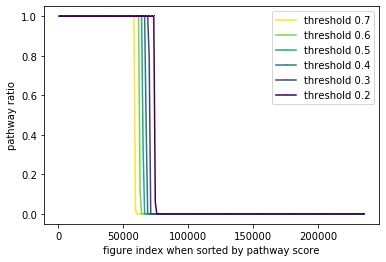

In [149]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

colors = cm.viridis(
    np.linspace(
        1, 0, len(range(int(threshold_start * 10), int(threshold_end * 10 + 1)))
    )
)
for threshold_integer, color in zip(
    range(int(threshold_end * 10), int(threshold_start * 10 - 1), -1 * step), colors
):
    threshold = threshold_integer / 10
    y_column = f"pathway_score_threshold_{threshold}"
    ax1.plot(
        ps_pathway_ratio_df["index"],
        ps_pathway_ratio_df[y_column],
        marker=",",
        c=color,
        label=f"threshold {threshold}",
    )

plt.legend(loc="upper right")
plt.xlabel("figure index when sorted by pathway score")
plt.ylabel("pathway ratio")
plt.show()

### Densities when Sorted by PMC Relevance Algorithm

When the figures are sorted by PMC's relevance algorithm, the density of pathways appears highest in the upper left corner of the plot.

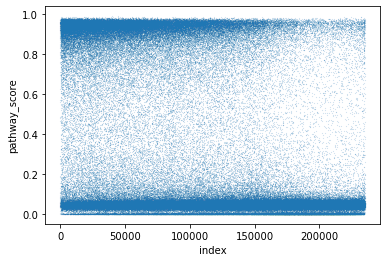

In [151]:
reset_analysis_df.plot.scatter(x="index", y="pathway_score", s=0.005)

### `pathway score` Distribution

As we would expect, `pathway score` starts high and decreases moving to the right when we sort by `pathway score`. The initial "high pathway score" plateau is more downward-sloped for these results from the 10k-trained model than were the results from the 2k-trained model. The "low pathway score/high other score" plateau has a small slope, while the previous results were almost flat.

This inverse sigmoidal curve has a rapid dropoff between the `pathway` and `other` plateaus, almost making it look like a step function. The dropoff occurs well before the midpoint of the x-axis (at ~50k, out of 235k total figures), indicating there are significantly fewer `pathway` figures than `other` figures.

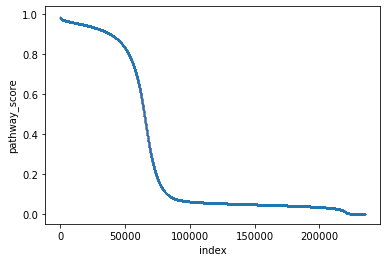

In [152]:
analysis_sorted_pathway_score_df.plot.scatter(x="index", y="pathway_score", s=0.001)

In [153]:
analysis_sorted_pathway_score_df

,index,pmc_ranked_result_index,figid,other_score,pathway_score
0,0,44602,PMC2881743__zbc0271020610006.jpg,0.011827,9.881734e-01
1,1,39762,PMC4375817__IJPharm-47-4-g003.jpg,0.012630,9.873697e-01
2,2,40908,PMC3167042__11689_2011_9087_Fig1_HTML.jpg,0.013961,9.860393e-01
3,3,64283,PMC4892782__mvv101f1p.jpg,0.014655,9.853455e-01
4,4,47719,PMC3660698__fpls-04-00150-g007.jpg,0.014751,9.852486e-01
...,...,...,...,...,...
235075,235075,112428,PMC3351816__1093fig7.jpg,1.000000,3.592438e-08
235076,235076,200297,PMC5780338__fphar-08-00976-g004.jpg,1.000000,3.495499e-08
235077,235077,195015,PMC3732610__ECAM2013-924541.006.jpg,1.000000,2.989699e-08
235078,235078,174160,PMC2732297__btn577f3.jpg,1.000000,1.762891e-08


In [155]:
current_file_basename = "get_and_analyze_predictions"
os.system(f'jupyter nbconvert --to html "{current_file_basename}.ipynb"')
os.system(f'mv "{current_file_basename}.html" "{str(paper_dir)}/notebooks/"')

0